In [57]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('white')
%matplotlib inline
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import knns
from surprise.model_selection import train_test_split
from surprise import Reader, Dataset
#prediction model imports
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.similarities import cosine, msd, pearson
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from rake_nltk import Rake
import string

In [58]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [59]:
review_df = pd.read_csv('review.csv')
review_df.head()

,business_id,date,user_id,stars,review_id,cool,text,useful,funny
0,b'ujmEBvifdJM6h6RLv4wQIg',b'2013-05-07 04:34:36',b'hG7b0MtEbXx5QzbzE6C_VA',1.0,b'Q1sbwvVQXV2734tPgoKj4Q',0,b'Total bill for this horrible service? Over $...,6,1
1,b'NZnhc2sEQy3RmzKTZnqtwQ',b'2017-01-14 21:30:33',b'yXQM5uF2jS6es16SJzNHfg',5.0,b'GJXCdrto3ASJOqKeVWPi6Q',0,"b""I *adore* Travis at the Hard Rock's new Kell...",0,0
2,b'WTqjgwHlXbSFevF32_DJVw',b'2016-11-09 20:09:03',b'n6-Gk65cPZL6Uz8qRm3NYw',5.0,b'2TzJjDVDEuAW6MR5Vuc1ug',0,"b""I have to say that this office really has it...",3,0
3,b'ikCg8xy5JIg_NGPx-MSIDA',b'2018-01-09 20:56:38',b'dacAIZ6fTM6mqwW5uxkskg',5.0,b'yi0R0Ugj_xUx_Nek0-_Qig',0,"b""Went in for a lunch. Steak sandwich was deli...",0,0
4,b'b1b1eb3uo-w561D0ZfCEiQ',b'2018-01-30 23:07:38',b'ssoyf2_x0EQMed6fgHeMyQ',1.0,b'11a8sVPMUFtaC7_ABRkmtw',0,b'Today was my second out of three sessions I ...,7,0


In [60]:
user_df = pd.read_csv('user.csv')
user_df.head()

,review_count,average_stars,user_id,compliment_plain,compliment_note,compliment_list,compliment_profile,elite,compliment_writer,cool,...,friends,compliment_cute,compliment_photos,compliment_more,compliment_cool,compliment_funny,name,funny,yelping_since,fans
0,95,4.03,b'l6BmjZMeQD3rDxWUbiAiow',1,1,0,0,"b'2015,2016,2017'",2,25,...,"b'c78V-rj8NQcQjOI8KP3UEA, alRMgPcngYSCJ5naFRBz...",0,0,0,1,1,b'Rashmi',17,b'2013-10-08 23:11:33',5
1,33,3.63,b'4XChL029mKr5hydo79Ljxg',0,0,0,0,b'',0,16,...,"b'kEBTgDvFX754S68FllfCaA, aB2DynOxNOJK9st2ZeGT...",0,0,0,1,1,b'Jenna',22,b'2013-02-21 22:29:06',4
2,16,3.71,b'bc8C_eETBWL0olvFSJJd0w',0,1,0,0,b'',0,10,...,"b'4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzM...",0,0,0,0,0,b'David',8,b'2013-10-04 00:16:10',0
3,17,4.85,b'dD0gZpBctWGdWo9WlGuhlA',2,0,0,0,b'',1,14,...,"b'RZ6wS38wnlXyj-OOdTzBxA, l5jxZh1KsgI8rMunm-GN...",0,0,0,0,0,b'Angela',4,b'2014-05-22 15:57:30',5
4,361,4.08,b'MM4RJAeH6yuaN8oZDSt0RA',57,16,1,0,"b'2015,2016,2017,2018'",25,665,...,"b'mbwrZ-RS76V1HoJ0bF_Geg, g64lOV39xSLRZO0aQQ6D...",0,5,1,80,80,b'Nancy',279,b'2013-10-23 07:02:50',39


In [61]:
biz_df = pd.read_csv('business.csv')
biz_df.head()

,attributes.Alcohol,attributes.WheelchairAccessible,attributes.Corkage,hours.Friday,attributes.HasTV,attributes,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.WiFi,city,...,attributes.BikeParking,attributes.DriveThru,attributes.Caters,hours.Wednesday,is_open,attributes.AcceptsInsurance,attributes.ByAppointmentOnly,attributes.Ambience,attributes.HappyHour,attributes.RestaurantsPriceRange2
0,NaN,NaN,NaN,NaN,NaN,{'GoodForKids': 'False'},NaN,NaN,NaN,Phoenix,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,u'full_bar',NaN,NaN,9:0-1:0,False,"{'RestaurantsReservations': 'True', 'GoodForMe...",NaN,False,u'no',Mississauga,...,False,NaN,True,9:0-0:0,1,NaN,NaN,"{'romantic': False, 'intimate': False, 'classy...",NaN,2
2,u'beer_and_wine',NaN,NaN,17:30-22:0,True,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",NaN,False,u'no',Charlotte,...,True,NaN,False,17:30-21:30,1,NaN,NaN,"{'romantic': False, 'intimate': False, 'touris...",NaN,2
3,NaN,NaN,NaN,8:0-17:0,NaN,NaN,NaN,NaN,NaN,Goodyear,...,NaN,NaN,NaN,8:0-17:0,1,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,7:0-23:0,NaN,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...",NaN,NaN,NaN,Charlotte,...,NaN,NaN,NaN,7:0-23:0,1,NaN,True,NaN,NaN,NaN


# Cleaning Data

In [62]:
# get business id, user id, rating for all reviews
review_df = review_df[['user_id','stars','business_id','text']]
review_df.business_id = review_df.business_id.apply(lambda x: x[2:-1])
review_df.user_id = review_df.user_id.apply(lambda x: x[2:-1])

In [63]:
# get user id, number of reviews and average rating for all users
user_df = user_df[['user_id','review_count']]
user_df.user_id = user_df.user_id.apply(lambda x: x[2:-1])

In [64]:
# get name, business id and review count for all businesses
biz_df = biz_df[['city','state','business_id']]

# EDA

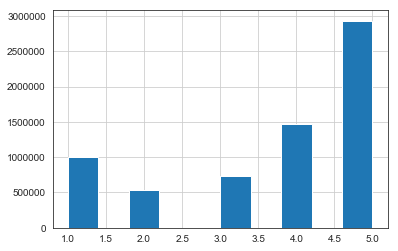

In [11]:
review_df.stars.hist()

In [10]:
user_df.describe()

,review_count
count,1.637138e+06
mean,2.228770e+01
std,7.692236e+01
min,0.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.500000e+01
max,1.327800e+04


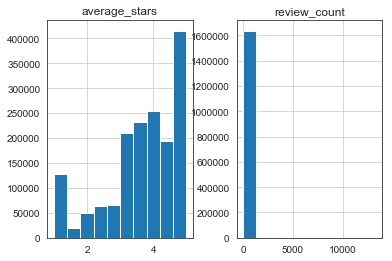

In [142]:
user_df.hist();

In [170]:
user_df

,user_id,review_count,average_stars
0,l6BmjZMeQD3rDxWUbiAiow,95,4.03
1,4XChL029mKr5hydo79Ljxg,33,3.63
2,bc8C_eETBWL0olvFSJJd0w,16,3.71
3,dD0gZpBctWGdWo9WlGuhlA,17,4.85
4,MM4RJAeH6yuaN8oZDSt0RA,361,4.08
...,...,...,...
1637133,oC4BjbB4I-wx5KBAO1k2Gg,2,4.50
1637134,LKd_-BT2GMWp8_1ho18kOg,8,4.00
1637135,ib_elCBhGOamS0AALkh4Og,4,3.40
1637136,WV27LoSFDG_YmiDKTLKKLA,1,3.00


In [146]:
biz_df.describe()

,review_count,stars
count,192609.000000,192609.000000
mean,33.538962,3.585627
std,110.135224,1.018458
min,3.000000,1.000000
25%,4.000000,3.000000
50%,9.000000,3.500000
75%,25.000000,4.500000
max,8348.000000,5.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x23a3ca6a0>,
      dtype=object)

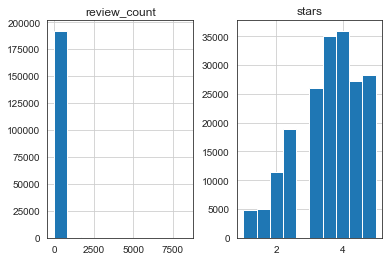

In [147]:
biz_df.hist()

In [10]:
print('Number of Users: ', len(review_df['user_id'].unique()))
print('Number of Businesses: ', len(review_df['business_id'].unique()))

Number of Users:  1637138
Number of Businesses:  192606


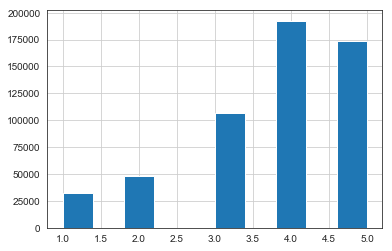

In [28]:
user_nv_df[user_nv_df.stars <=5].stars.hist()

# NLP on reviews

## NLP cleaning

In [65]:
review_nlp = review_df[['business_id','user_id','text']]

In [ ]:
review_nlp.business_id = review_nlp.business_id.apply(lambda x: x[2:-1])
review_nlp.user_id = review_nlp.user_id.apply(lambda x: x[2:-1])
review_nlp.text = review_nlp.text.apply(lambda x: x[2:-1])

In [ ]:
user_nlp = user_df[['review_count','user_id','average_stars']]
user_nlp.user_id = user_nlp.user_id.apply(lambda x: x[2:-1])

In [9]:
nlp_df = pd.merge(user_nlp,review_nlp)

In [10]:
nlp_df

,review_count,user_id,average_stars,business_id,text
0,95,l6BmjZMeQD3rDxWUbiAiow,4.03,XUA7xA7myMaCuN6G3xYdIA,Food here was bleh. Springs rolls were okay. M...
1,95,l6BmjZMeQD3rDxWUbiAiow,4.03,6sAR0qQp1TiEBKsALJDzVA,Went here for their Introduction to Glassblowi...
2,95,l6BmjZMeQD3rDxWUbiAiow,4.03,wib5LeUWBkxu67Rl3ruMDQ,I freakin' love Tiki bars and there aren't nea...
3,95,l6BmjZMeQD3rDxWUbiAiow,4.03,wygqdsRpyEWUtZL-biMsgw,This is a quite a gem for Cleveland suburbia. ...
4,95,l6BmjZMeQD3rDxWUbiAiow,4.03,SQk1H8KYdkTm4gElFZtlrA,Decent gym overall. The reason I prefer this g...
...,...,...,...,...,...
6685895,8,LKd_-BT2GMWp8_1ho18kOg,4.00,wDfz8ap9xWzj46mtNDcT9A,I am in town from Ohio and the place was recom...
6685896,4,ib_elCBhGOamS0AALkh4Og,3.40,sk2L4KcJbkkF6eHfjitGpg,"Meh, nothing special at all! Had the brisket s..."
6685897,1,WV27LoSFDG_YmiDKTLKKLA,3.00,bMIVYOyr0pOYHUDNsmSDwg,So disappointed in this establishment !! Attem...
6685898,1,WV27LoSFDG_YmiDKTLKKLA,3.00,bMIVYOyr0pOYHUDNsmSDwg,Extremely satisfied with returning here. My or...


In [3]:
nlp_df = pd.read_csv('user_review_nlp.csv')
nlp_df.drop('Unnamed: 0',axis=1,inplace=True)
nlp_df.drop('average_stars',axis=1,inplace=True)

In [4]:
nlp_df

,review_count,user_id,business_id,text
0,95,l6BmjZMeQD3rDxWUbiAiow,XUA7xA7myMaCuN6G3xYdIA,Food here was bleh. Springs rolls were okay. M...
1,95,l6BmjZMeQD3rDxWUbiAiow,6sAR0qQp1TiEBKsALJDzVA,Went here for their Introduction to Glassblowi...
2,95,l6BmjZMeQD3rDxWUbiAiow,wib5LeUWBkxu67Rl3ruMDQ,I freakin' love Tiki bars and there aren't nea...
3,95,l6BmjZMeQD3rDxWUbiAiow,wygqdsRpyEWUtZL-biMsgw,This is a quite a gem for Cleveland suburbia. ...
4,95,l6BmjZMeQD3rDxWUbiAiow,SQk1H8KYdkTm4gElFZtlrA,Decent gym overall. The reason I prefer this g...
...,...,...,...,...
6685895,8,LKd_-BT2GMWp8_1ho18kOg,wDfz8ap9xWzj46mtNDcT9A,I am in town from Ohio and the place was recom...
6685896,4,ib_elCBhGOamS0AALkh4Og,sk2L4KcJbkkF6eHfjitGpg,"Meh, nothing special at all! Had the brisket s..."
6685897,1,WV27LoSFDG_YmiDKTLKKLA,bMIVYOyr0pOYHUDNsmSDwg,So disappointed in this establishment !! Attem...
6685898,1,WV27LoSFDG_YmiDKTLKKLA,bMIVYOyr0pOYHUDNsmSDwg,Extremely satisfied with returning here. My or...


In [5]:
((nlp_df.review_count <= 120) & (nlp_df.review_count >=60)).sum()

745544

In [6]:
nlp_df.review_count.describe()

count    6.685900e+06
mean     1.228270e+02
std      3.635443e+02
min      0.000000e+00
25%      7.000000e+00
50%      2.400000e+01
75%      9.600000e+01
max      1.327800e+04
Name: review_count, dtype: float64

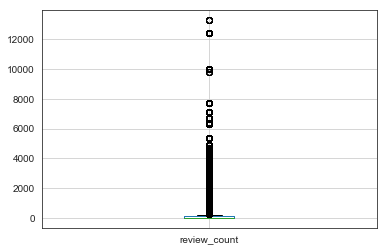

In [7]:
nlp_df.boxplot()

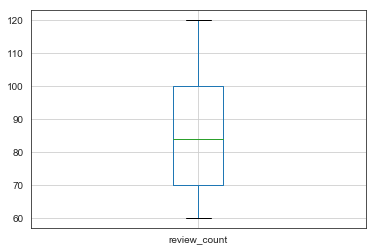

In [28]:
#feature enginering: get users with more than 60 reviews and less than 120 reviews)
nlp_filter_df = nlp_df[(nlp_df.review_count <= 120) & (nlp_df.review_count >=60)]
nlp_filter_df.boxplot()

In [29]:
nlp_filter_df

,review_count,user_id,business_id,text
0,95,l6BmjZMeQD3rDxWUbiAiow,XUA7xA7myMaCuN6G3xYdIA,Food here was bleh. Springs rolls were okay. M...
1,95,l6BmjZMeQD3rDxWUbiAiow,6sAR0qQp1TiEBKsALJDzVA,Went here for their Introduction to Glassblowi...
2,95,l6BmjZMeQD3rDxWUbiAiow,wib5LeUWBkxu67Rl3ruMDQ,I freakin' love Tiki bars and there aren't nea...
3,95,l6BmjZMeQD3rDxWUbiAiow,wygqdsRpyEWUtZL-biMsgw,This is a quite a gem for Cleveland suburbia. ...
4,95,l6BmjZMeQD3rDxWUbiAiow,SQk1H8KYdkTm4gElFZtlrA,Decent gym overall. The reason I prefer this g...
...,...,...,...,...
6683513,75,z8dHBJGGR8WJ5ol7zijKUg,YTCCJ3ShO-zg0dlx1nk6dw,A classic example of a celebrity chef slapping...
6683941,82,fjXx4PMMqnYkLsLQ2fyL3Q,AV6weBrZFFBfRGCbcRGO4g,Our stay was ok at most. Room not clean. Staff...
6684036,65,FetK6WnZ48HltLzDxzBIwA,BlD3wlsLIGRT5imf2hEljA,There needs to be more STARS than just 5!\nJef...
6684496,65,teAz9pxrSswiiSWN_-ZOxg,BIBWGO_r_1znnlmLbp4Nxg,They now charge a $22 per day resort fee. The...


In [30]:
biz_nlp = biz_df[['city','business_id','categories']]
biz_nlp

,city,business_id,categories
0,Phoenix,1SWheh84yJXfytovILXOAQ,"Golf, Active Life"
1,Mississauga,QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported..."
2,Charlotte,gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese"
3,Goodyear,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services"
4,Charlotte,HhyxOkGAM07SRYtlQ4wMFQ,"Plumbing, Shopping, Local Services, Home Servi..."
...,...,...,...
192604,North Las Vegas,nqb4kWcOwp8bFxzfvaDpZQ,"Water Purification Services, Water Heater Inst..."
192605,Newmarket,vY2nLU5K20Pee-FdG0br1g,"Books, Mags, Music & Video, Shopping"
192606,Phoenix,MiEyUDKTjeci5TMfxVZPpg,"Home Services, Contractors, Landscaping, Mason..."
192607,Mesa,zNMupayB2jEHVDOji8sxoQ,"Beauty & Spas, Barbers"


In [31]:
biz_nlp_vegas = biz_nlp[biz_nlp.city=='Las Vegas']

In [32]:
nlp_merge = pd.merge(biz_nlp_vegas,nlp_filter_df)

In [33]:
nlp_merge.dropna(inplace=True)

In [34]:
nlp_merge

,city,business_id,categories,review_count,user_id,text
0,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",72,-Yz2wIcsdJxUOFMbTgoKQA,"We went there for dinner the other night, bein..."
1,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",78,imINxn9Q__xZ7VUk3JzX0Q,I\'ve been always wanting to try Carluccio\'s ...
2,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"Restaurants, Italian",118,9RkL3lRhtAkPUIVyB8_07Q,A late sixties year old woman struggled to lig...
3,Las Vegas,nh_kQ16QAoXWwqZ05MPfBQ,"Event Planning & Services, Photographers, Prof...",116,6y3XgANQ4YGtR8Tv0pgl8Q,We were very impressed with Myron. \n\nWe met ...
4,Las Vegas,dFMxzHygTy6F873843dHAA,"Arcades, Arts & Entertainment",65,zMfryQcgMVOJrdPmCGJyeQ,Great employees great game choice! I'd highly ...
...,...,...,...,...,...,...
232651,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"Food, Coffee & Tea",62,Ru3XlA1NeRAYgtE0KUK7tg,I have lived in Las Vegas for about two weeks ...
232652,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"Food, Coffee & Tea",95,akUWuwkBS49fOHhmt6bouA,Stop by for breakfast and ordered a artesian h...
232653,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"Food, Coffee & Tea",84,WuSXUG2-08X8_IOYbPV-Jg,"Quick, friendly service. Store is clean and co..."
232654,Las Vegas,c1f_VAX1KIK8-JoVhjbYOw,"Massage, Beauty & Spas",110,Q-kpYHtrn6HKsXBpPDMy8A,Loved my 45 minute + hot stone massage. \nIf t...


In [35]:
nlp_merge.text = nlp_merge.text.apply(lambda x: x.replace('”','').replace('“',''))
for c in tqdm(string.punctuation):
    nlp_merge.text = nlp_merge.text.apply(lambda x: x.replace(c,""))

In [36]:
nlp_merge['Key_words'] = ''

for index, row in tqdm(nlp_merge.iterrows()):
    plot = row['text']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary with key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    
    # assigning the key words to the new column
    nlp_merge['Key_words'][index] = list(key_words_dict_scores.keys())

In [37]:
nlp_merge.categories = nlp_merge.categories.apply(lambda x: x.replace(' ','').replace('&',',').lower().split(','))


In [38]:
nlp_merge

,city,business_id,categories,review_count,user_id,text,Key_words
0,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",72,-Yz2wIcsdJxUOFMbTgoKQA,We went there for dinner the other night being...,"[friendly, lot, best, visit, wife, ny, veal, s..."
1,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",78,imINxn9Q__xZ7VUk3JzX0Q,Ive been always wanting to try Carluccios Im ...,"[side, try, carluccios, im, lounge, area, play..."
2,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",118,9RkL3lRhtAkPUIVyB8_07Q,A late sixties year old woman struggled to lig...,"[ate, half, side, neon, grand, piano, year, ch..."
3,Las Vegas,nh_kQ16QAoXWwqZ05MPfBQ,"[eventplanning, services, photographers, profe...",116,6y3XgANQ4YGtR8Tv0pgl8Q,We were very impressed with Myron nnWe met wit...,"[myron, nnwe, met, impressed, wow, intrusive, ..."
4,Las Vegas,dFMxzHygTy6F873843dHAA,"[arcades, arts, entertainment]",65,zMfryQcgMVOJrdPmCGJyeQ,Great employees great game choice Id highly re...,"[huge, plus, fun, likes, games, end, clean, an..."
...,...,...,...,...,...,...,...
232651,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",62,Ru3XlA1NeRAYgtE0KUK7tg,I have lived in Las Vegas for about two weeks ...,"[decided, location, like, go, inside, even, th..."
232652,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",95,akUWuwkBS49fOHhmt6bouA,Stop by for breakfast and ordered a artesian h...,"[friendly, put, quickly, made, ones, making, w..."
232653,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",84,WuSXUG2-08X8_IOYbPV-Jg,Quick friendly service Store is clean and coff...,"[clean, made, ordered, conveniently, located, ..."
232654,Las Vegas,c1f_VAX1KIK8-JoVhjbYOw,"[massage, beauty, spas]",110,Q-kpYHtrn6HKsXBpPDMy8A,Loved my 45 minute hot stone massage nIf the ...,"[kept, saying, arm, 15, yes, thats, say, answe..."


In [39]:
nlp_merge['bag_of_words'] = ''
columns = nlp_merge[['categories','Key_words']]
for index, row in tqdm(nlp_merge.iterrows()):
    words = ''
    for col in columns:
        words = words + ' '.join(row[col])+ ' '
        
    nlp_merge['bag_of_words'][index] = words

In [40]:
nlp_merge

,city,business_id,categories,review_count,user_id,text,Key_words,bag_of_words
0,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",72,-Yz2wIcsdJxUOFMbTgoKQA,We went there for dinner the other night being...,"[friendly, lot, best, visit, wife, ny, veal, s...",restaurants italian friendly lot best visit wi...
1,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",78,imINxn9Q__xZ7VUk3JzX0Q,Ive been always wanting to try Carluccios Im ...,"[side, try, carluccios, im, lounge, area, play...",restaurants italian side try carluccios im lou...
2,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",118,9RkL3lRhtAkPUIVyB8_07Q,A late sixties year old woman struggled to lig...,"[ate, half, side, neon, grand, piano, year, ch...",restaurants italian ate half side neon grand p...
3,Las Vegas,nh_kQ16QAoXWwqZ05MPfBQ,"[eventplanning, services, photographers, profe...",116,6y3XgANQ4YGtR8Tv0pgl8Q,We were very impressed with Myron nnWe met wit...,"[myron, nnwe, met, impressed, wow, intrusive, ...",eventplanning services photographers professio...
4,Las Vegas,dFMxzHygTy6F873843dHAA,"[arcades, arts, entertainment]",65,zMfryQcgMVOJrdPmCGJyeQ,Great employees great game choice Id highly re...,"[huge, plus, fun, likes, games, end, clean, an...",arcades arts entertainment huge plus fun likes...
...,...,...,...,...,...,...,...,...
232651,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",62,Ru3XlA1NeRAYgtE0KUK7tg,I have lived in Las Vegas for about two weeks ...,"[decided, location, like, go, inside, even, th...",food coffee tea decided location like go insid...
232652,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",95,akUWuwkBS49fOHhmt6bouA,Stop by for breakfast and ordered a artesian h...,"[friendly, put, quickly, made, ones, making, w...",food coffee tea friendly put quickly made ones...
232653,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",84,WuSXUG2-08X8_IOYbPV-Jg,Quick friendly service Store is clean and coff...,"[clean, made, ordered, conveniently, located, ...",food coffee tea clean made ordered convenientl...
232654,Las Vegas,c1f_VAX1KIK8-JoVhjbYOw,"[massage, beauty, spas]",110,Q-kpYHtrn6HKsXBpPDMy8A,Loved my 45 minute hot stone massage nIf the ...,"[kept, saying, arm, 15, yes, thats, say, answe...",massage beauty spas kept saying arm 15 yes tha...


In [41]:
nlp_merge.to_csv('BoWs1.csv')

In [44]:
nlp_merge[nlp_merge.user_id == 'Q-kpYHtrn6HKsXBpPDMy8A']

,city,business_id,categories,review_count,user_id,text,Key_words,bag_of_words
5288,Las Vegas,7wMCJ9NqL9eBEX4WdJWuIA,"[steakhouses, restaurants]",110,Q-kpYHtrn6HKsXBpPDMy8A,Estevan was our server for a table of 5 nHe wa...,"[could, friendly, knowledgeable, fast, wishing...",steakhouses restaurants could friendly knowled...
21915,Las Vegas,LtXy1VinKWfuLFslVarKRw,"[restaurants, american(traditional), burgers, ...",110,Q-kpYHtrn6HKsXBpPDMy8A,I really dont know what all the hype is about ...,"[burgers, recommend, mediocre, almost, tastele...",restaurants american(traditional) burgers brea...
139306,Las Vegas,tWasMHaS6ZD-xRhevpoqkw,"[comfortfood, seafood, restaurants, southern, ...",110,Q-kpYHtrn6HKsXBpPDMy8A,Closed on a Saturday at 330 They offered a fre...,"[came, back, three, hours, 330, closed, saturd...",comfortfood seafood restaurants southern cajun...
139307,Las Vegas,tWasMHaS6ZD-xRhevpoqkw,"[comfortfood, seafood, restaurants, southern, ...",110,Q-kpYHtrn6HKsXBpPDMy8A,After receiving an extremely rude compliment o...,"[vegas, specifically, rude, employee, receivin...",comfortfood seafood restaurants southern cajun...
147445,Las Vegas,Ccjo5j4A5-gVaBbuHAqzVA,"[hotels, travel, hotels, eventplanning, services]",110,Q-kpYHtrn6HKsXBpPDMy8A,I cant rave enough about this hotel nIt is a b...,"[lights, loved, boy, cant, expect, hotel, nit,...",hotels travel hotels eventplanning services li...
170283,Las Vegas,cYwJA2A6I12KNkm2rtXd5g,"[restaurants, burgers, american(traditional)]",110,Q-kpYHtrn6HKsXBpPDMy8A,Waiter ALEX Rating F I love Gorgon Ramsay but...,"[want, food, came, class, gordon, refilled, ta...",restaurants burgers american(traditional) want...
232654,Las Vegas,c1f_VAX1KIK8-JoVhjbYOw,"[massage, beauty, spas]",110,Q-kpYHtrn6HKsXBpPDMy8A,Loved my 45 minute hot stone massage nIf the ...,"[kept, saying, arm, 15, yes, thats, say, answe...",massage beauty spas kept saying arm 15 yes tha...


In [132]:
nlp_merge[nlp_merge.user_id == 'fCExFIeu2BT35FSx2Yz2aA']

,city,business_id,categories,review_count,user_id,text,Key_words,bag_of_words
3397,Las Vegas,ujHiaprwCQ5ewziu0Vi9rw,"[american(new), buffets, restaurants]",185,fCExFIeu2BT35FSx2Yz2aA,Well what I will say first is that the line is...,"[say, first, find, youtypical, strip, setback,...",american(new) buffets restaurants say first fi...
4575,Las Vegas,rTZVcJZ8G80i6NjLw0SW8Q,"[hotels&travel, eventplanning&services, arts&e...",185,fCExFIeu2BT35FSx2Yz2aA,Back with another carefully crafted reviewThis...,"[ample, bright, lighting, way, thatnnpool, poo...",hotels&travel eventplanning&services arts&ente...
5895,Las Vegas,Wxxvi3LZbHNIDwJ-ZimtnA,"[shoppingcenters, resorts, arts&entertainment,...",185,fCExFIeu2BT35FSx2Yz2aA,The Venetian embodies the meaning of luxury Th...,"[signature, scent, venetian, embodies, recomme...",shoppingcenters resorts arts&entertainment hot...
5896,Las Vegas,Wxxvi3LZbHNIDwJ-ZimtnA,"[shoppingcenters, resorts, arts&entertainment,...",185,fCExFIeu2BT35FSx2Yz2aA,Well well wellI cannot express enough what a b...,"[stayed, 2017, ample, chairs, availablenncasin...",shoppingcenters resorts arts&entertainment hot...
8341,Las Vegas,vATbGMxLd9cZ3VY_GZAIJw,"[nightlife, restaurants, beachbars, american(t...",185,fCExFIeu2BT35FSx2Yz2aA,Let me start by saying that I love going to t...,"[small, handful, next, dark, cloud, place, thr...",nightlife restaurants beachbars american(tradi...
...,...,...,...,...,...,...,...,...
440297,Las Vegas,yhgUyctWczUN13MinNgZ3w,"[hotels, casinos, homeservices, arts&entertain...",185,fCExFIeu2BT35FSx2Yz2aA,My recent stay at the Westgate LV was in a Con...,"[lobby, provided, breakfast, evening, hors, do...",hotels casinos homeservices arts&entertainment...
440624,Las Vegas,ByFMv3p5X1aNeZhU61rDcA,"[hotels&travel, casinos, restaurants, hotels, ...",185,fCExFIeu2BT35FSx2Yz2aA,This hotel is a great value The rooms are well...,"[worth, trying, tower, pizzeria, view, roxys, ...",hotels&travel casinos restaurants hotels event...
440625,Las Vegas,ByFMv3p5X1aNeZhU61rDcA,"[hotels&travel, casinos, restaurants, hotels, ...",185,fCExFIeu2BT35FSx2Yz2aA,Welcome to another updated review this lovely ...,"[another, updated, review, soso, rather, bland...",hotels&travel casinos restaurants hotels event...
443910,Las Vegas,aq5dfc469jZ0-xhIYLgCNw,"[bars, nightlife, lounges]",185,fCExFIeu2BT35FSx2Yz2aA,The atmosphere here is good the food is above ...,"[much, lot, either, talk, amongst, efficient, ...",bars nightlife lounges much lot either talk am...


# Recommend User to User

In [4]:
# nlp_merge = pd.read_csv('BoWs1.csv')
# nlp_merge.drop('Unnamed: 0',axis=1, inplace=True)


CPU times: user 6.35 s, sys: 972 ms, total: 7.32 s
Wall time: 7.45 s


In [45]:
nlp_merge

,city,business_id,categories,review_count,user_id,text,Key_words,bag_of_words
0,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",72,-Yz2wIcsdJxUOFMbTgoKQA,We went there for dinner the other night being...,"[friendly, lot, best, visit, wife, ny, veal, s...",restaurants italian friendly lot best visit wi...
1,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",78,imINxn9Q__xZ7VUk3JzX0Q,Ive been always wanting to try Carluccios Im ...,"[side, try, carluccios, im, lounge, area, play...",restaurants italian side try carluccios im lou...
2,Las Vegas,PZ-LZzSlhSe9utkQYU8pFg,"[restaurants, italian]",118,9RkL3lRhtAkPUIVyB8_07Q,A late sixties year old woman struggled to lig...,"[ate, half, side, neon, grand, piano, year, ch...",restaurants italian ate half side neon grand p...
3,Las Vegas,nh_kQ16QAoXWwqZ05MPfBQ,"[eventplanning, services, photographers, profe...",116,6y3XgANQ4YGtR8Tv0pgl8Q,We were very impressed with Myron nnWe met wit...,"[myron, nnwe, met, impressed, wow, intrusive, ...",eventplanning services photographers professio...
4,Las Vegas,dFMxzHygTy6F873843dHAA,"[arcades, arts, entertainment]",65,zMfryQcgMVOJrdPmCGJyeQ,Great employees great game choice Id highly re...,"[huge, plus, fun, likes, games, end, clean, an...",arcades arts entertainment huge plus fun likes...
...,...,...,...,...,...,...,...,...
232651,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",62,Ru3XlA1NeRAYgtE0KUK7tg,I have lived in Las Vegas for about two weeks ...,"[decided, location, like, go, inside, even, th...",food coffee tea decided location like go insid...
232652,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",95,akUWuwkBS49fOHhmt6bouA,Stop by for breakfast and ordered a artesian h...,"[friendly, put, quickly, made, ones, making, w...",food coffee tea friendly put quickly made ones...
232653,Las Vegas,vIAEWbTJc657yN8I4z7whQ,"[food, coffee, tea]",84,WuSXUG2-08X8_IOYbPV-Jg,Quick friendly service Store is clean and coff...,"[clean, made, ordered, conveniently, located, ...",food coffee tea clean made ordered convenientl...
232654,Las Vegas,c1f_VAX1KIK8-JoVhjbYOw,"[massage, beauty, spas]",110,Q-kpYHtrn6HKsXBpPDMy8A,Loved my 45 minute hot stone massage nIf the ...,"[kept, saying, arm, 15, yes, thats, say, answe...",massage beauty spas kept saying arm 15 yes tha...


In [46]:
rec_df = nlp_merge[['user_id','bag_of_words']]

In [47]:
rec_df[rec_df.user_id == '--3l8wysfp49Z2TLnyT0vg']

,user_id,bag_of_words
134446,--3l8wysfp49Z2TLnyT0vg,cardealers nightlife automotive buffets wineba...


In [48]:
groupby = rec_df.groupby('user_id')['bag_of_words'].apply(' '.join).reset_index()

In [49]:
groupby.bag_of_words = groupby.bag_of_words.apply(lambda x: x.replace('&', ' '))

In [50]:
groupby

,user_id,bag_of_words
0,--0zxhZTSLZ7w1hUD2bEwA,food grocery american(traditional) breakfast b...
1,--3l8wysfp49Z2TLnyT0vg,cardealers nightlife automotive buffets wineba...
2,--O1bi61whjxObUkR0a16w,american(traditional) restaurants american(new...
3,--RlSfc-QmcHFGHyX6aVjA,gastropubs nightlife restaurants american(new)...
4,--WLHsm-AC4jcol2gOkmCQ,nightlife lounges restaurants bars american(tr...
...,...,...
39079,zz6ebkIVHwThVzQbsJKJ8w,restaurants sushibars seafood new favorite sus...
39080,zz7S6pd1WowWwPbTx5wglg,fish chips pubs nightlife gastropubs bars brit...
39081,zzL4E_gdoSCtgNhW4BPY8w,american(traditional) restaurants breakfast br...
39082,zzhO1jW4skCDWNrWtSLbTw,arts entertainment axethrowing recreationcente...


In [51]:
tf = TfidfVectorizer(analyzer='word',min_df=10)
tfidf_matrix = tf.fit_transform(groupby['bag_of_words'])
tfidf_matrix.shape

(39084, 28020)

In [52]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)


In [53]:
cosine_sim 

array([[1.        , 0.01000038, 0.04034804, ..., 0.07264192, 0.01391691,
        0.02033162],
       [0.01000038, 1.        , 0.11450862, ..., 0.02931956, 0.00323203,
        0.06660576],
       [0.04034804, 0.11450862, 1.        , ..., 0.0518663 , 0.03016378,
        0.06502534],
       ...,
       [0.07264192, 0.02931956, 0.0518663 , ..., 1.        , 0.00816683,
        0.04954764],
       [0.01391691, 0.00323203, 0.03016378, ..., 0.00816683, 1.        ,
        0.01203031],
       [0.02033162, 0.06660576, 0.06502534, ..., 0.04954764, 0.01203031,
        1.        ]])

# Put most similar users together

In [54]:
indices = pd.Series(groupby.set_index('user_id').index)


In [55]:
indices

0        --0zxhZTSLZ7w1hUD2bEwA
1        --3l8wysfp49Z2TLnyT0vg
2        --O1bi61whjxObUkR0a16w
3        --RlSfc-QmcHFGHyX6aVjA
4        --WLHsm-AC4jcol2gOkmCQ
                  ...          
39079    zz6ebkIVHwThVzQbsJKJ8w
39080    zz7S6pd1WowWwPbTx5wglg
39081    zzL4E_gdoSCtgNhW4BPY8w
39082    zzhO1jW4skCDWNrWtSLbTw
39083    zzo--VpSQh8PpsGVeMC1dQ
Name: user_id, Length: 39084, dtype: object

In [48]:
def match_users(user_id):
    
    recommended_users = []
    
    # gettin the index of the user 
    idx = indices[indices == user_id].index[0]
    
    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    
    # getting the indexes of the 5 most similar user
    top_5_indexes = list(score_series.iloc[1:6].index)
    
    # populating the list with the user_id of the best 5 matching users
    for i in top_5_indexes:
        recommended_users.append(list(groupby.user_id)[i])
        
    return recommended_users, score_series

In [49]:
match_users('--0zxhZTSLZ7w1hUD2bEwA')

NameError: name 'indices' is not defined